### Loading necessary libraries

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img,img_to_array
import pickle
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import load_model

Using TensorFlow backend.


In [2]:
model=load_model("saved.h5")

c:\users\shravan\anaconda3\envs\tf18\lib\site-packages\keras\engine\saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Processing  text data

#### Loading the text from file

In [2]:
file=open("Flickr8k.token.txt",'r')
text=file.read()
file.close()

In [3]:
print(text[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


#### Function that returns dictionanry which contains image name as keys and their value is list of captions

In [4]:
def categorize_description(text):
    mapping=dict()
    for i in text.split("\n"):
        token=i.split()
        if len(token)<2:
            continue
        key=token[0].split(".")
        key=key[0]
        desc=token[1:]
        desc=" ".join(desc)
        if key not in mapping:
            mapping[key]=list()
        mapping[key].append(desc)
    return mapping

#### Calling the function

In [10]:
description=categorize_description(text)
print("Loaded %d keys"%len(description))

Loaded 8092 keys


#### Function to clean the caption texts

In [13]:
def clean_desc(mapping):
    table=str.maketrans("","",string.punctuation)
    for key,value in mapping.items():
        complete_desc=[]
        for i in range(len(value)):
            desc=value[i]
            desc=desc.split()
            desc=[word.lower() for word in desc ]
            desc=[word.translate(table) for word in desc]
            desc=[word for word in desc if len(word)>1]
            desc=[word for word in desc if word.isalpha()]
            desc=" ".join(desc)
            complete_desc.append(desc)
        mapping[key]=complete_desc
    return mapping
            
    

#### Calling the function

In [14]:
description=clean_desc(description)

#### Saving the cleaned caption texts

In [16]:
def save_desc(description):
    lines=list()
    for key,values in description.items():
        for desc in values:
            lines.append(key+" "+desc)
    data="\n".join(lines)
    return data
data=save_desc(description)
with open("saved_description.txt","w") as fl:
    fl.write(data)
    fl.close()
        

## Processing the image 

In [5]:
#image directory
directory="Flicker8k_Dataset\\"


#### Initializing Inception Model

In [6]:
model = InceptionV3()


In [8]:
model = InceptionV3()
#Popping the last FC layer
model.layers.pop()
model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
print(model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

#### Extract features from each photo

In [11]:
features = dict()
for name in os.listdir(directory):
    temp_name=name.split(".")[0]
    if temp_name not in list(description.keys()):
        continue
# load an image from file
    else:
        
        
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            # prepare the image for the VGG model
        image = preprocess_input(image)
            # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature[0]
        print('>%s' % name)
    

>1000268201_693b08cb0e.jpg
>1001773457_577c3a7d70.jpg
>1002674143_1b742ab4b8.jpg
>1003163366_44323f5815.jpg
>1007129816_e794419615.jpg
>1007320043_627395c3d8.jpg
>1009434119_febe49276a.jpg
>1012212859_01547e3f17.jpg
>1015118661_980735411b.jpg
>1015584366_dfcec3c85a.jpg
>101654506_8eb26cfb60.jpg
>101669240_b2d3e7f17b.jpg
>1016887272_03199f49c4.jpg
>1019077836_6fc9b15408.jpg
>1019604187_d087bf9a5f.jpg
>1020651753_06077ec457.jpg
>1022454332_6af2c1449a.jpg
>1022454428_b6b660a67b.jpg
>1022975728_75515238d8.jpg
>102351840_323e3de834.jpg
>1024138940_f1fefbdce1.jpg
>102455176_5f8ead62d5.jpg
>1026685415_0431cbf574.jpg
>1028205764_7e8df9a2ea.jpg
>1030985833_b0902ea560.jpg
>103106960_e8a41d64f8.jpg
>103195344_5d2dc613a3.jpg
>103205630_682ca7285b.jpg
>1032122270_ea6f0beedb.jpg
>1032460886_4a598ed535.jpg
>1034276567_49bb87c51c.jpg
>104136873_5b5d41be75.jpg
>1042020065_fb3d3ba5ba.jpg
>1042590306_95dea0916c.jpg
>1045521051_108ebc19be.jpg
>1048710776_bb5b0a5c7c.jpg
>1052358063_eae6744153.jpg
>10534218

>1338523142_57fce8229b.jpg
>133905560_9d012b47f3.jpg
>1339596997_8ac29c1841.jpg
>1341787777_4f1ebb1793.jpg
>1342766791_1e72f92455.jpg
>1342780478_bacc32344d.jpg
>1343426964_cde3fb54e8.jpg
>1346051107_9cdc14e070.jpg
>1346529555_e916816cfe.jpg
>134724228_30408cd77f.jpg
>1347519824_e402241e4f.jpg
>1348113612_5bfc5f429e.jpg
>1348304997_afe60a61df.jpg
>1348891916_ebd4413033.jpg
>134894450_dadea45d65.jpg
>1348947380_14f0fc1237.jpg
>1348957576_c4a78eb974.jpg
>1350811702_2ce7cfd0c5.jpg
>1350948838_fdebe4ff65.jpg
>1351315701_6580b51c41.jpg
>1351764581_4d4fb1b40f.jpg
>135235570_5698072cd4.jpg
>1352398363_9cc8ffcce9.jpg
>1352410176_af6b139734.jpg
>1354318519_2f9baed754.jpg
>1355450069_c0675b0706.jpg
>1355703632_5683a4b6fb.jpg
>1355833561_9c43073eda.jpg
>1355935187_2c99648138.jpg
>1355945307_f9e01a9a05.jpg
>1356543628_c13ebe38fb.jpg
>1356796100_b265479721.jpg
>1357689954_72588dfdc4.jpg
>1357724865_4faf4e1418.jpg
>1357753846_6185e26040.jpg
>1358089136_976e3d2e30.jpg
>1358892595_7a37c45788.jpg
>1359

>1579287915_4257c54451.jpg
>1579798212_d30844b4c5.jpg
>1580172290_e19067e0dd.jpg
>1580671272_3e99d94305.jpg
>1581822598_0ae23074f1.jpg
>1584315962_5b0b45d02d.jpg
>1594038143_57f299aa8a.jpg
>159712188_d530dd478c.jpg
>1597319381_1e80d9e39c.jpg
>1597557856_30640e0b43.jpg
>1598085252_f3219b6140.jpg
>1600208439_e94527b80f.jpg
>160541986_d5be2ab4c1.jpg
>160566014_59528ff897.jpg
>160585932_fa6339f248.jpg
>1606988704_fe330878a3.jpg
>160792599_6a7ec52516.jpg
>160805827_5e6646b753.jpg
>1616016569_673de1d678.jpg
>161669933_3e7d8c7e2c.jpg
>161905204_247c6ca6de.jpg
>1620397000_3883e3ecd3.jpg
>162152393_52ecd33fc5.jpg
>1622619190_d0b51aff28.jpg
>1625306051_7099519baa.jpg
>1626754053_81126b67b6.jpg
>162743064_bb242faa31.jpg
>1643915227_9f48068772.jpg
>1650280501_29810b46e5.jpg
>1655781989_b15ab4cbff.jpg
>1659358133_95cd1027bd.jpg
>1659358141_0433c9bf99.jpg
>1659396176_ced00a549f.jpg
>1662261486_db967930de.jpg
>166321294_4a5e68535f.jpg
>1663454406_5e2cf8c5bb.jpg
>1663751778_90501966f0.jpg
>166433861_7

>2074764331_90a9962b52.jpg
>2075041394_0b3ea1822d.jpg
>2075321027_c8fcbaf581.jpg
>2075493556_b763648389.jpg
>207584893_63e73c5c28.jpg
>2076428547_738e0a132f.jpg
>2076865206_53918c820c.jpg
>2076906555_c20dc082db.jpg
>2077079696_03380d218b.jpg
>207731022_988f6afb35.jpg
>2077346067_0a3a5aae65.jpg
>2078311270_f01c9eaf4c.jpg
>2079110798_ad1370a646.jpg
>2079152458_40712c3b40.jpg
>207930963_af3a2f1784.jpg
>2079554580_f18d5c181b.jpg
>2080033499_6be742f483.jpg
>2081141788_38fa84ce3c.jpg
>2081446176_f97dc76951.jpg
>2081615901_13092cac56.jpg
>2081679622_6f1442367d.jpg
>2082005167_a0d6a70020.jpg
>2083434441_a93bc6306b.jpg
>2083778090_3aecaa11cc.jpg
>2084103826_ffd76b1e3e.jpg
>2084157130_f288e492e4.jpg
>2084217208_7bd9bc85e5.jpg
>2085078076_b9db242d21.jpg
>2085255128_61224cc47f.jpg
>2085400856_ae09df33a7.jpg
>2085403342_a17b0654fe.jpg
>2085557551_7a88d01d4e.jpg
>2085726719_a57a75dbe5.jpg
>2086513494_dbbcb583e7.jpg
>2086532897_b8714f2237.jpg
>2086534745_1e4ab80078.jpg
>2086678529_b3301c2d71.jpg
>208

>2208631481_3e4a5675e1.jpg
>2209496328_2a34fd201d.jpg
>2209888959_d636b1be0b.jpg
>2210368267_0615754b48.jpg
>2211593099_4a4f1c85d2.jpg
>2212472643_80238475b5.jpg
>2213113526_beeb4f9bdc.jpg
>2214132302_80064fd79d.jpg
>2214847438_4993210d4c.jpg
>2215136723_960edfea49.jpg
>2215165918_2bf5b659dd.jpg
>2216568822_84c295c3b0.jpg
>2216695423_1362cb25f3.jpg
>2217328285_b1d55c17ca.jpg
>2217728745_92b6779016.jpg
>2218334049_e649dbdb1a.jpg
>2218519240_cac5aab53c.jpg
>2218609886_892dcd6915.jpg
>2218743570_9d6614c51c.jpg
>2218843713_cf28ea319e.jpg
>2218907190_5f43bf5e4d.jpg
>221973402_ecb1cd51f1.jpg
>2219805467_370ee1b7aa.jpg
>2219805677_7b7cc188c7.jpg
>2219959872_988e6d498e.jpg
>2220175999_081aa9cce8.jpg
>2220185725_45d4fa68d9.jpg
>2220612655_030413b787.jpg
>2221818690_9003756d33.jpg
>2222186636_85e03e0b75.jpg
>2222498879_9e82a100ab.jpg
>2222559267_6fd31e3941.jpg
>2223382277_9efa58ec45.jpg
>222369445_5b6af347dd.jpg
>2224450291_4c133fabe8.jpg
>2224995194_518859d97d.jpg
>2225231022_1632d0a5aa.jpg
>22

>2322327298_7948338390.jpg
>2322334640_d4d22619ff.jpg
>2322593776_e6aaf69e80.jpg
>2322601965_748d59dc57.jpg
>2324779494_5e72d29171.jpg
>2324917982_f3db8c11e9.jpg
>2324979199_4193ef7537.jpg
>2325258180_6217dd17eb.jpg
>2325386353_1f1a05e1ce.jpg
>2325816912_b3bb41cdbb.jpg
>2326730558_75c20e5033.jpg
>2326879311_555ebef188.jpg
>2327088022_478dbd2c17.jpg
>2327240505_e73cc73246.jpg
>2328104318_5a43ca170c.jpg
>2328106090_b7c2725501.jpg
>2328616978_fb21be2b87.jpg
>232874193_c691df882d.jpg
>2330062180_355ccbceb5.jpg
>2330536645_2d36b516e1.jpg
>2330843604_b8d75d6ac7.jpg
>2331510788_986809bbb4.jpg
>233242340_09963100a3.jpg
>2332540384_4cf26406a9.jpg
>233270519_d60d4518fa.jpg
>2332986053_864db84971.jpg
>233327292_3bcbc3783f.jpg
>2333288869_8c01e4c859.jpg
>2333584535_1eaf9baf3e.jpg
>233361142_d9d5f0cae9.jpg
>2333816000_7105d0ffac.jpg
>2335428699_4eba9b6245.jpg
>2335619125_2e2034f2c3.jpg
>2335634931_7e9e8c2959.jpg
>2337377811_8c81b40a64.jpg
>2337757064_08c4033824.jpg
>2337809114_899ba61330.jpg
>23379

>2423138514_950f79e432.jpg
>242324909_06d5a6c44b.jpg
>2423292784_166ee54e0b.jpg
>2423550887_ffc9bbcf71.jpg
>2423856014_8df0e7f656.jpg
>2423894412_d952d5d103.jpg
>2424111022_4e332b8aee.jpg
>2424398046_1a55c71376.jpg
>2424976964_98f58a0618.jpg
>2425262733_afe0718276.jpg
>242558556_12f4d1cabc.jpg
>242559369_9ae90ed0b4.jpg
>2426215757_e008a91fcb.jpg
>2426303900_0a8d52eb14.jpg
>2426724282_237bca30b5.jpg
>2426781076_e3f4d2685c.jpg
>2426828433_ce894d1c54.jpg
>2427490900_5b7a8874b9.jpg
>2427558437_3e839056d7.jpg
>2428086758_bce4733f7e.jpg
>2428094795_d3a8f46046.jpg
>2428275562_4bde2bc5ea.jpg
>2428751994_88a6808246.jpg
>2428797297_7fc3c862db.jpg
>2428959030_bdffc2812e.jpg
>2429212017_77fc107699.jpg
>2429272699_8a9699775e.jpg
>2429729667_42effc165d.jpg
>2429978680_1e18a13835.jpg
>2430860418_fd0726f414.jpg
>2431120202_b24fe2333a.jpg
>2431470169_0eeba7d602.jpg
>2431723485_bc6b8e6418.jpg
>2431832075_00aa1a4457.jpg
>2432038587_5e4148e277.jpg
>2432061076_0955d52854.jpg
>2432709509_2a4d0c833f.jpg
>243

>2521062020_f8b983e4b2.jpg
>2521213787_ca9b5a1758.jpg
>252124738_796599e94b.jpg
>2521770311_3086ca90de.jpg
>2521878609_146143708e.jpg
>2521938720_911ac092f7.jpg
>2521938802_853224f378.jpg
>2521983429_33218366bd.jpg
>2522230304_1581d52961.jpg
>2522297487_57edf117f7.jpg
>2522467011_cc825d89ac.jpg
>2522540026_6ee8ab4c6a.jpg
>2522809984_2e8a7df4fb.jpg
>2524003134_580e74328b.jpg
>2524084967_a5e011b73d.jpg
>252504549_135b0db5a3.jpg
>2525232298_cf42d415ab.jpg
>2525270674_4ab536e7ec.jpg
>2525455265_f84ba72bd7.jpg
>2525666287_638ab5e784.jpg
>2525716531_e6dedee421.jpg
>252578659_9e404b6430.jpg
>2526041608_a9775ab8d7.jpg
>2526585002_10987a63f3.jpg
>2527163162_d0fb802992.jpg
>2527303359_6c3dc3f282.jpg
>2527713011_b0ec25aa54.jpg
>252802010_3d47bee500.jpg
>252846811_7b250935a7.jpg
>2528489543_546c1ca81f.jpg
>2528521798_fb689eba8d.jpg
>2528547068_7d37479b9b.jpg
>2528552898_9e49a7033f.jpg
>2529116152_4331dabf50.jpg
>2529205842_bdcb49d65b.jpg
>2531531628_b4a5041680.jpg
>2531837969_6f28637811.jpg
>25319

>2621771656_09a620da6d.jpg
>2622517932_57c52c376f.jpg
>2622624460_207dbcc4cf.jpg
>2622971954_59f192922d.jpg
>2623146491_b64698b875.jpg
>2623247254_3bfc795121.jpg
>2623496164_68ffeb5067.jpg
>2623560640_0445c9a138.jpg
>2623930900_b9df917b82.jpg
>2623939135_0cd02ffa5d.jpg
>2623982903_58ec7c5026.jpg
>2624044128_641b38c0cf.jpg
>262439544_e71cd26b24.jpg
>2624457062_89efc497a8.jpg
>262446581_06ef7d9445.jpg
>262570082_6364f58f33.jpg
>2626158969_ac09aeb88d.jpg
>262642489_f5c6b9e65b.jpg
>262681159_e5fed3acf0.jpg
>2628331789_c7f7d90e5d.jpg
>2629027962_9cc3b46527.jpg
>2629294578_853a08bb43.jpg
>2629295654_59ea1472a1.jpg
>2629334536_11f2d49e05.jpg
>2629346153_155ba73ae9.jpg
>2629402527_6dfc5c504b.jpg
>2629445284_83390e83af.jpg
>262963190_a78b799e89.jpg
>2630507245_bea4804288.jpg
>2630806789_6835bbae95.jpg
>2631300484_be8621d17b.jpg
>2631625732_75b714e685.jpg
>2632111399_b3c1630f8e.jpg
>263216826_acf868049c.jpg
>263231469_e85c74f5fd.jpg
>263233914_d25004e4cd.jpg
>2632366677_43dee456a5.jpg
>263238112

>2718024196_3ff660416a.jpg
>2718027742_70a72f99ae.jpg
>2718049631_e7aa74cb9b.jpg
>2718376488_3c62f7642c.jpg
>2718495608_d8533e3ac5.jpg
>2719101587_4ba70dee14.jpg
>2719102611_fef453bf30.jpg
>2720215226_5a98ff2bd3.jpg
>2720985888_8f5920e8cf.jpg
>272156850_c4445a53f4.jpg
>2721656220_5f4cda8bc1.jpg
>272283076_2d4aa1d5cf.jpg
>2723477522_d89f5ac62b.jpg
>2723929323_70b93a74ea.jpg
>2724485630_7d2452df00.jpg
>272546805_536c719648.jpg
>2726262796_03bd63a155.jpg
>2726301121_95a2fbd22b.jpg
>2727051596_be65bfb3d3.jpg
>2728276857_3f83757ef2.jpg
>2728486640_cc2a31d2b0.jpg
>2728813605_cfc943e1ab.jpg
>2729147877_c3ec3445bf.jpg
>272940778_a184dbea42.jpg
>2729655904_1dd01922fb.jpg
>2729685399_56c0e104b1.jpg
>272988646_1588bde6a8.jpg
>2730819220_b58af1119a.jpg
>2730938963_c4ed3e2258.jpg
>2730994020_64ac1d18be.jpg
>2731171552_4a808c7d5a.jpg
>273248777_eaf0288ab3.jpg
>2732625904_4fbb653434.jpg
>2733659177_d74a00995b.jpg
>2734219983_fe86a60bf9.jpg
>2734669176_c272b42597.jpg
>2735158990_56ff6bf9b0.jpg
>273529

>2837640996_0183db8d93.jpg
>2837799692_2f1c50722a.jpg
>2837808847_5407af1986.jpg
>2837908308_8bc25c6b02.jpg
>2838085973_42b6e9b5b1.jpg
>2838125339_3dd314e315.jpg
>2838619742_eed855d8a8.jpg
>2839038702_e168128665.jpg
>2839532455_36a7dc4758.jpg
>2839789830_89668775a4.jpg
>2839807428_efe42423f2.jpg
>2839890871_4b7c7dbd96.jpg
>2839932205_3c9c27cd99.jpg
>2840344516_8e15fe2668.jpg
>2841449931_84a05850ec.jpg
>2842032768_9d9ce04385.jpg
>2842439618_fb20fe2215.jpg
>2842609837_b3a0b383f7.jpg
>284279868_2ca98e3dcd.jpg
>2842849030_89548af61c.jpg
>2842865689_e37256d9ce.jpg
>2843695880_eeea6c67db.jpg
>2844018783_524b08e5aa.jpg
>284441196_8ebb216d0d.jpg
>2844641033_dab3715a99.jpg
>2844747252_64567cf14a.jpg
>2844846111_8c1cbfc75d.jpg
>2844963839_ff09cdb81f.jpg
>2845246160_d0d1bbd6f0.jpg
>2845691057_d4ab89d889.jpg
>2845845721_d0bc113ff7.jpg
>2846037553_1a1de50709.jpg
>2846785268_904c5fcf9f.jpg
>2846843520_b0e6211478.jpg
>2847514745_9a35493023.jpg
>2847615962_c330bded6e.jpg
>2847859796_4d9cb0d31f.jpg
>28

>2917057791_3d68a055ca.jpg
>2917843040_7c9caaaa8a.jpg
>2918653119_f535fc25c4.jpg
>2918769188_565dd48060.jpg
>2918880895_e61f74f2f0.jpg
>2919459517_b8b858afa3.jpg
>291952021_f111b0fb3d.jpg
>2920305300_a5b1b2329a.jpg
>2920516901_23d8571419.jpg
>2920969723_83918fe909.jpg
>2921094201_2ed70a7963.jpg
>2921112724_5cb85d7413.jpg
>2921198890_6f70dfbf4c.jpg
>2921430836_3b4d062238.jpg
>2921578694_a46ae0d313.jpg
>2921670682_6a77a6c3e9.jpg
>2921793132_ef19f1dd44.jpg
>2922222717_12195af92d.jpg
>2922512807_d382528a93.jpg
>2922807898_b5a06d5c70.jpg
>2922973230_5a769ef92a.jpg
>2922981282_203f04bf9b.jpg
>2923475135_a6b6e13d26.jpg
>2923497185_c64004ff2d.jpg
>2923825744_ca125353f0.jpg
>2923891109_ea0cc932ed.jpg
>2924259848_effb4dcb82.jpg
>2924483864_cfdb900a13.jpg
>2924870944_90ff9eca1a.jpg
>2924884815_63826aa60d.jpg
>2924884899_f512c84332.jpg
>2924908529_0ecb3cdbaa.jpg
>2925242998_9e0db9b4a2.jpg
>2925577165_b83d31a7f6.jpg
>2925737498_57585a7ed9.jpg
>2925760802_50c1e84936.jpg
>2926233397_71e617f3a3.jpg
>2

>300765528_8c8f709dda.jpg
>3008370541_ce29ce49f0.jpg
>3009018821_ba47396e24.jpg
>3009035153_715e39b440.jpg
>3009047603_28612247d2.jpg
>300922408_05a4f9938c.jpg
>3009383694_e045c6169e.jpg
>3009644534_992e9ea2a7.jpg
>3012513414_86180c44cb.jpg
>3013469764_30e84e9a0d.jpg
>3014015906_fdba461f36.jpg
>3014080715_f4f0dbb56e.jpg
>3014169370_fc4059352e.jpg
>3014546644_d53db746ec.jpg
>3014773357_f66bd09290.jpg
>3014986976_0e7b858970.jpg
>3015368588_ef0a06076d.jpg
>3015863181_92ff43f4d8.jpg
>3015891201_2c1a9e5cd7.jpg
>3015898903_70bebb8903.jpg
>3016178284_ec50a09e8c.jpg
>3016200560_5bf8a70797.jpg
>3016521240_2ef20834b6.jpg
>3016606751_0e8be20abd.jpg
>3016651969_746bd36e68.jpg
>3016708786_3591106cca.jpg
>3016726158_4d15b83b06.jpg
>3016741474_72b4355198.jpg
>3016759846_062663f8ab.jpg
>3017203816_5dc2a6b392.jpg
>3017220118_6a9212dfdb.jpg
>3017373346_3a34c3fe9d.jpg
>3017521547_f5ef8848e3.jpg
>3017656907_c3b137e070.jpg
>3018304737_0a46fc5f1d.jpg
>3018467501_a03d404413.jpg
>3018847610_0bf4d7e43d.jpg
>30

>3091338773_9cf10467b4.jpg
>3091382602_60b9b53ed1.jpg
>3091580843_178042c50b.jpg
>3091594712_2166604334.jpg
>3091912922_0d6ebc8f6a.jpg
>3091916691_b1c96669c6.jpg
>3091921457_83eee69591.jpg
>3091962081_194f2f3bd4.jpg
>3092200805_dd1f83ddbe.jpg
>3092370204_029b6bc10a.jpg
>309238565_2d5d8dc8bf.jpg
>3092756650_557c5f2d03.jpg
>3093970461_825b0cac2f.jpg
>3093971101_543237971d.jpg
>3094064787_aed1666fc9.jpg
>3094278545_febac56382.jpg
>309430053_cc58bcc36a.jpg
>3094317837_b31cbf969e.jpg
>3094568845_d0b56c5651.jpg
>3095137758_bdd1e613dd.jpg
>3095225232_2e6e6dc92e.jpg
>3096163135_584901a5ae.jpg
>309687244_4bdf3b591f.jpg
>3096918227_f9d26a7db2.jpg
>3097171315_0ba7d283b1.jpg
>3097196395_ec06075389.jpg
>309771854_952aabe3cc.jpg
>3097776588_312932e438.jpg
>3098336319_a7e5b061d0.jpg
>3098707588_5096d20397.jpg
>3098714492_19939e3b19.jpg
>3098824948_23c31df031.jpg
>3099091086_f75f0ce09d.jpg
>3099264059_21653e2536.jpg
>3099504809_565e17e49d.jpg
>3099694681_19a72c8bdc.jpg
>3099923914_fd450f6d51.jpg
>3099

>3163281186_e2f43dfb5f.jpg
>3163323414_d1ce127aa6.jpg
>3163477256_073605e06e.jpg
>3163563871_cef3cf33ea.jpg
>3164328039_2c56acf594.jpg
>3164347907_2813f8ff0b.jpg
>3164415865_612f9fd8bc.jpg
>3164423279_9b27cb6a06.jpg
>3165123595_8db9f918bf.jpg
>3165750962_e2e3843679.jpg
>316577571_27a0e0253e.jpg
>3165826902_6bf9c4bdb2.jpg
>3165936115_cb4017d94e.jpg
>3166366760_e43cf66eda.jpg
>3166578139_33500f7e8a.jpg
>3166969425_b5ace2f9c2.jpg
>3167365436_c379bda282.jpg
>3167379087_927ff05a35.jpg
>3168123064_d1983b8f92.jpg
>316833109_6500b526dc.jpg
>3168354472_866fe70d36.jpg
>3168796547_0c14b368f9.jpg
>3168841415_c0705a327a.jpg
>3169276423_6918dd4da1.jpg
>3169394115_2193158cee.jpg
>3169591322_d0b6d0cd04.jpg
>3169777863_d745865784.jpg
>3170110692_d1e0e66cee.jpg
>3170551725_1276644eab.jpg
>3170802797_3c851bb475.jpg
>3170856184_efabfd0297.jpg
>3170897628_3054087f8c.jpg
>3171035252_dba286ae5c.jpg
>3171066023_ec60ba30f3.jpg
>317109978_cb557802e1.jpg
>3171188674_717eee0183.jpg
>3171250845_5ae0d2a8bc.jpg
>317

>3225037367_a71fa86319.jpg
>3225058391_a12d38d911.jpg
>3225226381_9fe306fb9e.jpg
>3225296260_2ee72b4917.jpg
>3225310099_d8e419ba56.jpg
>3225478803_f7a9a41a1d.jpg
>3225880532_c8d5d1d798.jpg
>3225998968_ef786d86e0.jpg
>3226254560_2f8ac147ea.jpg
>3226541300_6c81711e8e.jpg
>3226796100_08c49cfa5c.jpg
>3227111573_c82f7d68b1.jpg
>3227140905_1d7e30e4c4.jpg
>3227148358_f152303584.jpg
>3227423095_5049951eab.jpg
>3227499174_07feb26337.jpg
>3227594168_3351722aae.jpg
>322791392_aa3b142f43.jpg
>3228069008_edb2961fc4.jpg
>3228517564_74b00a923b.jpg
>3228793611_8f260ea500.jpg
>3228960484_9aab98b91a.jpg
>3229282764_a4a515f4e2.jpg
>3229442620_fd47d01b59.jpg
>3229519418_040f05ced1.jpg
>3229730008_63f8ca2de2.jpg
>3229821595_77ace81c6b.jpg
>3229898555_16877f5180.jpg
>3229913073_e7857a5966.jpg
>3230101918_7d81cb0fc8.jpg
>3230132205_dccfafa5ee.jpg
>3231237864_8cb1c6d863.jpg
>3231575742_31732664cf.jpg
>3231596071_f0c522a639.jpg
>3231751379_10ebf7150c.jpg
>3231880001_193a579b97.jpg
>3232030272_b2480a5fe7.jpg
>3

>3286111436_891ae7dab9.jpg
>3286193613_fc046e8016.jpg
>3286198467_8880be127e.jpg
>3286222970_1fa445e38f.jpg
>3286406057_a1668655af.jpg
>3286543624_7a327f79ae.jpg
>3286620180_4b00e93e8e.jpg
>3286761458_34af7e4499.jpg
>3286822339_5535af6b93.jpg
>3287236038_8998e6b82f.jpg
>3287549827_04dec6fb6e.jpg
>3287904625_f68ca5cea7.jpg
>3287963317_186491ee78.jpg
>3287969199_08e775d896.jpg
>3288173388_03bc2a844d.jpg
>3288174272_2daa06d360.jpg
>3288274849_07ff76ee93.jpg
>3288839246_fdb00395ae.jpg
>328916930_e4d4be1730.jpg
>3289433994_4c67aab384.jpg
>3289817083_4e78e1c05a.jpg
>3289893683_d4cc3ce208.jpg
>3290105461_7590f23371.jpg
>3290465391_258429e2f9.jpg
>3291255271_a185eba408.jpg
>3291587911_81fc33300e.jpg
>3292016893_24d14c8b4f.jpg
>3292277400_f95cdd13d1.jpg
>3293018193_e4e0c8db7c.jpg
>3293596075_973b0bfd08.jpg
>3293642024_e136b74a55.jpg
>3293751136_b0ce285dc3.jpg
>3293751640_d81a6f3a0c.jpg
>3293753378_7a8ddb98b2.jpg
>3293945284_6a04e477a9.jpg
>3294179574_4f67e67d6f.jpg
>3294202771_e8ee78a439.jpg
>3

>3350614753_5624e181b3.jpg
>3350671534_2a5d45a961.jpg
>3350785999_462f333c44.jpg
>3350786891_6d39b234e9.jpg
>3351111378_b5d80783a1.jpg
>3351357065_a6a9b3d485.jpg
>3351360323_91bb341350.jpg
>3351370405_e417e38f52.jpg
>3351418768_596ef7fd6f.jpg
>3351493005_6e5030f596.jpg
>3351586010_7ffaa90ea8.jpg
>3351596152_bf283f03d1.jpg
>3351667632_00f586a30c.jpg
>3351667846_ac43118ae5.jpg
>3351704877_28dea303aa.jpg
>3352199368_b35f25793e.jpg
>3352531708_a65dd694b1.jpg
>3352697012_751b079bbb.jpg
>3352791995_8db4979aca.jpg
>3352871762_c9e88592d3.jpg
>3353036763_4cbeba03b2.jpg
>3353278454_2f3a4d0bbc.jpg
>3353328134_dd9ed0edab.jpg
>3353400143_8b9543f7dc.jpg
>3353950389_1153d5e452.jpg
>3353962769_ba48691bc6.jpg
>3354063643_1d8814eb13.jpg
>3354075558_3b67eaa502.jpg
>3354200211_35348e47d8.jpg
>3354330935_de75be9d2f.jpg
>3354414391_a3908bd4ff.jpg
>3354474353_daf9e168cf.jpg
>3354489242_dd529ffa1f.jpg
>3354883962_170d19bfe4.jpg
>3355494822_61353a224d.jpg
>3355683198_715fb1a2ac.jpg
>3355756569_b430a29c2a.jpg
>

>3416013671_98b5c75046.jpg
>3416091866_a96003d652.jpg
>3416246113_1745559b6b.jpg
>3416339125_0860d3d1eb.jpg
>3416460533_d5819fbf69.jpg
>341665272_80d4d61376.jpg
>3417037373_67f7db2dd2.jpg
>3417102649_5c0b2f4b4d.jpg
>3417143124_6feb8290cc.jpg
>3417231408_6ce951c011.jpg
>3417662443_2eaea88977.jpg
>3417672954_46b75dea8d.jpg
>3417788829_cfdbc34d2c.jpg
>3418504074_083f0bb68d.jpg
>3419197575_aa5b84a9f0.jpg
>3419238351_ac18b440c0.jpg
>3419634480_c390f62a6e.jpg
>3419916411_72934edcdb.jpg
>3420064875_0349a75d69.jpg
>3420260768_26a600b844.jpg
>3420278866_1d17c12713.jpg
>3420284416_a90af1fb7a.jpg
>3420323191_d66e003264.jpg
>3420338549_bd78d35243.jpg
>3420469425_2980b4cd30.jpg
>3421104520_6a71185b3c.jpg
>3421129418_088af794f7.jpg
>3421131122_2e4bde661e.jpg
>3421177332_a05741cfa4.jpg
>3421480658_b3518b6819.jpg
>3421547427_53411b6278.jpg
>3421706363_a3e22a4908.jpg
>3421789737_f625dd17ed.jpg
>3421928157_69a325366f.jpg
>3422146099_35ffc8680e.jpg
>3422219732_3d0be52cc3.jpg
>3422394336_e465f60b7c.jpg
>3

>3472485022_5d03e9852d.jpg
>3472540184_b0420b921a.jpg
>3472703856_568d9778b5.jpg
>3473264983_67917a931f.jpg
>3473320907_3884a7203b.jpg
>3473534758_1ae3847781.jpg
>3474176841_cde2bee67c.jpg
>3474265683_43b1033d94.jpg
>3474330484_a01d8af624.jpg
>3474406285_01f3d24b71.jpg
>3474912569_7165dc1d06.jpg
>3474958471_9106beb07f.jpg
>3474985008_0a827cd340.jpg
>3474985112_24ef46e82d.jpg
>3474985382_26e1560338.jpg
>3474999131_788cbf253f.jpg
>3475005101_6f6e437459.jpg
>3475092236_cf45d383c7.jpg
>3475111806_f0d2927707.jpg
>347543966_b2053ae78c.jpg
>3475552729_a3abd81ee6.jpg
>3475581086_a533567561.jpg
>3476237185_9389c536a3.jpg
>3476381830_3751dd9339.jpg
>3476451861_5b9c9ce191.jpg
>3476709230_6439305bf2.jpg
>3477315700_52a4d740a5.jpg
>3477369101_8e0c61d8f4.jpg
>3477672764_7f07657a26.jpg
>3477681171_b1bb8b211d.jpg
>3477683327_d9e6a2a64f.jpg
>3477712686_8428614c75.jpg
>3477715432_79d82487bb.jpg
>3477778668_81ff0a68e0.jpg
>3477977145_4df89d69a1.jpg
>3478084305_9e1219c3b6.jpg
>3478176372_7c510a0cef.jpg
>3

>3532761259_14026c1e96.jpg
>3532782283_341f0381a3.jpg
>3533145793_5d69f72e41.jpg
>3533394378_1513ec90db.jpg
>3533451027_b078e4631b.jpg
>3533470072_87a5b595ba.jpg
>3533484468_0787830d49.jpg
>3533660418_f3a73a257c.jpg
>3533775651_9d7e93dacf.jpg
>3533922605_a2b1e276f6.jpg
>3534046564_4f8546e364.jpg
>3534183988_3763593dfb.jpg
>3534512991_f9fd66f165.jpg
>3534548254_7bee952a0e.jpg
>3534668485_6887629ff0.jpg
>3534824784_7133119316.jpg
>3534952095_975cca0056.jpg
>3535056297_e16f014cb7.jpg
>3535084928_858544f49a.jpg
>3535284878_f90f10236e.jpg
>3535304540_0247e8cf8c.jpg
>3535372414_4c51c86fc4.jpg
>3535664885_c848c0faee.jpg
>3535768334_a3924bcccd.jpg
>3535879138_9281dc83d5.jpg
>3536561454_e75993d903.jpg
>3537201804_ce07aff237.jpg
>3537218226_478d2e4f26.jpg
>3537400880_8f410d747d.jpg
>3537452619_3bd79f24e0.jpg
>3537474810_cf676b3259.jpg
>3537520829_aab733e16c.jpg
>3537806062_c50d814aba.jpg
>3537920947_6c5a956f47.jpg
>3538021517_b930dc76fc.jpg
>3538213870_9856a76b2a.jpg
>3538527033_df13112d51.jpg
>

>3591458156_f1a9a33918.jpg
>3591461782_687e320042.jpg
>3591462960_86045906bd.jpg
>359173181_a75c950aeb.jpg
>3592968286_b63c81bcd2.jpg
>3592992234_6d3fe58a70.jpg
>3593220756_5c416c3ceb.jpg
>3593222804_c187808ac3.jpg
>3593392955_a4125087f6.jpg
>3593538248_dffa1a5ed4.jpg
>3593556797_46b49a02a8.jpg
>3594029059_cee1f4c59a.jpg
>3594566537_55bd712fdb.jpg
>3594822096_e1144b85d6.jpg
>3595080592_5fd55570e5.jpg
>3595216998_0a19efebd0.jpg
>3595398879_13e33b8916.jpg
>3595408539_a7d8aabc24.jpg
>3595412126_4020d4643b.jpg
>3595643050_d312e4b652.jpg
>3595992258_6f192e6ae7.jpg
>3596131692_91b8a05606.jpg
>3596428453_8cfdec4869.jpg
>3596459539_a47aa80612.jpg
>3596959859_a7cb1e194b.jpg
>3597146852_3d000a5d5f.jpg
>3597210806_95b07bb968.jpg
>3597326009_3678a98a43.jpg
>3597354819_0069aaf16e.jpg
>3597715122_45878432ec.jpg
>3597921737_3fd1d0665b.jpg
>3597924257_d0da3c5fe6.jpg
>359837950_9e22ffe6c2.jpg
>3598447435_f66cd10bd6.jpg
>3599124739_b7e60cf477.jpg
>3599392711_8264881de2.jpg
>3599442049_e448c7c9b2.jpg
>35

>3655326478_4472c5c630.jpg
>3655773435_c234e94820.jpg
>365584746_681f33fa46.jpg
>3655964639_21e76383d0.jpg
>3656030945_fa003bd696.jpg
>3656104088_a0d1642fa9.jpg
>3656151153_b4ed5d94c4.jpg
>3656206975_09e6ce58bd.jpg
>3656225270_cdf89e3240.jpg
>3656906086_7034f69ab6.jpg
>3657016761_d553e514d9.jpg
>3657209354_cde9bbd2c5.jpg
>3657503733_9888ccf05e.jpg
>365759754_6cf7068c9a.jpg
>3658016590_f761e72dc3.jpg
>3658427967_6e2e57458d.jpg
>3658733605_fbcf570843.jpg
>3659090958_a56913ca68.jpg
>3659686168_49c3abcee1.jpg
>3659769138_d907fd9647.jpg
>3660361818_e05367693f.jpg
>3660826540_481d25fbb0.jpg
>3661072592_2e693cd5a0.jpg
>3661239105_973f8216c4.jpg
>3661659196_6ed90f96c0.jpg
>3662406028_29b9e46a6f.jpg
>3662871327_b128d25f04.jpg
>3662909101_21b9e59a3e.jpg
>3662963630_8f097e38d4.jpg
>3663307538_468739e4c3.jpg
>3663951804_868982f3f9.jpg
>3664297064_a4d45cbbbc.jpg
>3664928753_7b0437fedf.jpg
>3665169936_01ae94c9fd.jpg
>3665179773_dd217416fc.jpg
>366548880_3d3e914746.jpg
>3665549027_d7fb05d157.jpg
>366

>3726730085_2468ee9220.jpg
>3727740053_3baa94ffcb.jpg
>3727752439_907795603b.jpg
>3728015645_b43a60258b.jpg
>3728164558_52729baefa.jpg
>3728256505_7f8db8270d.jpg
>3728695560_00ec1ca492.jpg
>3729405438_6e79077ab2.jpg
>3729525173_7f984ed776.jpg
>3730011219_588cdc7972.jpg
>3730011701_5352e02286.jpg
>3730457171_e66dde8c91.jpg
>373219198_149af371d9.jpg
>3732728142_86364a706e.jpg
>3733074526_82aa8d5f8d.jpg
>373394550_1b2296b8c4.jpg
>3736786640_70df13be2c.jpg
>3737492755_bcfb800ed1.jpg
>3737539561_d1dc161040.jpg
>3737711435_113ccd0a52.jpg
>3738685861_8dfff28760.jpg
>3738789925_7d17dbdf25.jpg
>3739833689_a0038545bd.jpg
>374103776_0de490c1b0.jpg
>374103842_17873ce505.jpg
>374103966_2987706be1.jpg
>374104006_7f32c8c5de.jpg
>374124237_51f62b6937.jpg
>3741462565_cc35966b7a.jpg
>374176648_ba4b88c221.jpg
>3741827382_71e93298d0.jpg
>3744832122_2f4febdff6.jpg
>3745451546_fc8ec70cbd.jpg
>374567836_3ae12ecffb.jpg
>3747543364_bf5b548527.jpg
>374828031_9d087da5cf.jpg
>3751594676_edfbfa0688.jpg
>375171241_

>458183774_afe65abf67.jpg
>458213442_12c59e61a0.jpg
>458735196_176e7df6b3.jpg
>459284240_5a4167bf92.jpg
>459778335_857d8ffebf.jpg
>459814265_d48ba48978.jpg
>460195978_fc522a4979.jpg
>460350019_af60511a3b.jpg
>460478198_83039f2593.jpg
>460781612_6815c74d37.jpg
>460935487_75b2da7854.jpg
>460973814_5eacd1ced4.jpg
>461019788_bc0993dabd.jpg
>461505235_590102a5bf.jpg
>462080147_ca088e6541.jpg
>462198798_89e2df0358.jpg
>462288558_b31a8a976f.jpg
>463786229_b54c9a3436.jpg
>463875230_f19e83d6df.jpg
>463978865_c87c6ca84c.jpg
>464116251_1ac4bc91f8.jpg
>464251704_b0f0c4c87a.jpg
>464506846_1734302b58.jpg
>464527562_a18f095225.jpg
>465859490_b077219424.jpg
>465994762_1760e83c5d.jpg
>466176275_f40d37851e.jpg
>466956209_2ffcea3941.jpg
>466956675_a2fb6bf901.jpg
>467858872_f3431df682.jpg
>467960888_6943257534.jpg
>468102269_135938e209.jpg
>468141298_3154d717e1.jpg
>468310111_d9396abcbd.jpg
>468608014_09fd20eb9b.jpg
>468871328_72990babd4.jpg
>468911753_cc595f5da0.jpg
>468918320_9c275b877f.jpg
>468930779_8

>535123126_c06c1ab9bf.jpg
>535249787_0fcaa613a0.jpg
>535309053_ec737abde8.jpg
>535399240_0714a6e950.jpg
>535529555_583d89b7f2.jpg
>535830521_aa971319fc.jpg
>536495604_b22bbc905a.jpg
>536537638_f5ee42410b.jpg
>536721406_884ab8fece.jpg
>536828916_b763b82949.jpg
>537222436_ab406234ce.jpg
>537225246_dd0e2158a7.jpg
>537230454_1f09199476.jpg
>537359971_6e28f5e66e.jpg
>537390477_7dd3407f96.jpg
>537479916_c033897fac.jpg
>537532165_e4b7c0e61a.jpg
>537559285_29be110134.jpg
>537579448_a7f92cef58.jpg
>537628742_146f2c24f8.jpg
>537758332_8beb9cf522.jpg
>538825260_a4a8784b75.jpg
>539493423_9d7d1b77fa.jpg
>539493431_744eb1abaa.jpg
>539667015_fd0a3bea07.jpg
>539676201_c8f1f04952.jpg
>539705321_99406e5820.jpg
>539744890_85e63f5854.jpg
>539750844_02a07ec524.jpg
>539751252_2bd88c456b.jpg
>539761097_5c6c70425b.jpg
>539801139_7258ee437f.jpg
>540338917_57069687be.jpg
>540604040_bec822c144.jpg
>540721368_12ac732c6c.jpg
>540873795_ae62ae6f60.jpg
>541046380_513e295384.jpg
>541063419_a5f3672d59.jpg
>541063517_3

>871290666_4877e128c0.jpg
>872135364_8c1e47d163.jpg
>872512911_ca383b40e4.jpg
>872622575_ba1d3632cc.jpg
>873633312_a756d8b381.jpg
>874665322_9ad05c4065.jpg
>875731481_a5a0a09934.jpg
>878758390_dd2cdc42f6.jpg
>880220939_0ef1c37f1f.jpg
>881725588_efabbcd96a.jpg
>883040210_3c4a10f030.jpg
>887108308_2da97f15ef.jpg
>888425986_e4b6c12324.jpg
>888517718_3d5b4b7b43.jpg
>890734502_a5ae67beac.jpg
>892340814_bdd61e10a4.jpg
>894928353_002a3d5f06.jpg
>895502702_5170ada2ee.jpg
>897406883_f09f673d94.jpg
>897621891_efb1e00d1d.jpg
>899810584_61e1578d3f.jpg
>90011335_cfdf9674c2.jpg
>900144365_03cd1899e3.jpg
>905355838_3a43fdfd4e.jpg
>909191414_1cf5d85821.jpg
>909808296_23c427022d.jpg
>911527312_f81ee36b97.jpg
>911795495_342bb15b97.jpg
>917574521_74fab68514.jpg
>918886676_3323fb2a01.jpg
>923550133_ac9d7a2932.jpg
>925491651_57df3a5b36.jpg
>927420680_6cba7c040a.jpg
>929679367_ff8c7df2ee.jpg
>930126921_1b94605bdc.jpg
>930748509_8ca5cf5c24.jpg
>933118213_b35b0b62a7.jpg
>934375844_dd149fed18.jpg
>937559727_ae


#### Saving the above dictionary as a pickle file

In [ ]:
with open('extracted_features.pickle', 'wb') as handle:
    pickle.dump(features, handle)


In [12]:
len(features)

8091

In [21]:
train_features = load(open("extracted_features.pickle", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=8091


### Preparing traning data

#### Loading test and train image IDs

In [44]:
def  load_set(filename):
    file=open(filename,"r")
    text=file.read()
    file.close()
    dataset=list()
    for line in text.split("\n"):
        if len(line)<1:
            continue
        data=line.split(".")[0]
        dataset.append(data)
    return set(dataset)
        
train=load_set("Flickr_8k.trainImages.txt")
test=list(load_set("Flickr_8k.testImages.txt"))

print("Train Dataset",len(train))        
print("Test Dataset",len(test))        
    

Train Dataset 6000
Test Dataset 1000


{'3095225232_2e6e6dc92e',
 '293881927_ac62900fd4',
 '3208074567_ac44aeb3f3',
 '1386964743_9e80d96b05',
 '398662202_97e5819b79',
 '3299820401_c2589186c5',
 '3225310099_d8e419ba56',
 '2436081047_bca044c1d3',
 '2575647360_f5de38c751',
 '3347666612_659e6e2207',
 '3200120942_59cfbb3437',
 '2251747182_6b67a3ab8b',
 '3688858505_e8afd1475d',
 '2450453051_f1d4a78ab4',
 '246055693_ccb69ac5c6',
 '132489044_3be606baf7',
 '352981175_16ff5c07e4',
 '3070031806_3d587c2a66',
 '3239021459_a6b71bb400',
 '3251648670_9339943ba2',
 '3584534971_b44f82c4b9',
 '3498327617_d2e3db3ee3',
 '229862312_1a0ba19dab',
 '56489627_e1de43de34',
 '3244747165_17028936e0',
 '2914206497_5e36ac6324',
 '3364151356_eecd07a23e',
 '211295363_49010ca38d',
 '3259991972_fce3ab18b2',
 '493621130_152bdd4e91',
 '1282392036_5a0328eb86',
 '3192266178_f9bf5d3dba',
 '1584315962_5b0b45d02d',
 '2148916767_644ea6a7fa',
 '522063319_33827f1627',
 '3333921867_6cc7d7c73d',
 '1258913059_07c613f7ff',
 '3028969146_26929ae0e8',
 '2292406847_f366350600

#### Loading train description

In [19]:
def load_cleaned_desc(filename,train):
    new_mapping=dict()
    file=open(filename)
    text=file.read()
    file.close()
    for line in text.split("\n"):
        token=line.split()
        image_id,desc=token[0],token[1:]
        if (image_id not in train):
            continue
        if image_id not in new_mapping:
            new_mapping[image_id]=list()
        desc="starting "+" ".join(desc)+" ending"
        new_mapping[image_id].append(desc)
    return new_mapping
mapping=load_cleaned_desc("saved_description.txt",train)
print("Descriptions %d "%len(mapping)) 

Descriptions 6000 


#### Total number of captions

In [20]:
all_train_captions=[]
for key,value in mapping.items():
    for cap in value:
        all_train_captions.append(cap)
len(all_train_captions)


30000

#### Creating vocabulary of words with count greater than 3

In [23]:
word_count_threshold = 3
word_count = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_count[w] = word_count.get(w, 0) + 1

vocab = [w for w in word_count if word_count[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_count), len(vocab)))

preprocessed words 7577 -> 3470


In [24]:
#this dictionary contains words as key and index as value
word2ix={}
#this dictionary contains index as key and words as value
ix2word={}
ix=1
for w in vocab:
    word2ix[w]=ix
    ix2word[ix]=w
    ix+=1

In [34]:
vocaab_size=len(vocab)

In [26]:
#function that finds max length on a caption
def find_max(text):
    temp=0
    temp1=99999
    for i,j in enumerate(text):
        j=j.split()
        temp=max(temp,len(j))
    return temp

max_length=find_max(all_train_captions)

In [27]:
max_length

34

#### Loading gloal word2vec 

In [32]:
f=open("glove.6B.200d.txt",encoding="utf-8")
embeddings_index={}
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype="float32")
    embeddings_index[word]=coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
    

Found 400000 word vectors.


#### Creating a dictionary to hold 200dim value for all words in training caption

In [37]:
embedding_dim = 200

embedding_matrix = np.zeros((vocaab_size+1 , embedding_dim))

for word, i in word2ix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

### Model Building

In [39]:
inputs1=Input(shape=(2048,))
f1=Dropout(0.5)(inputs1)
f2=Dense(256,activation='relu')(f1)
inputs2=Input(shape=(max_length,))
se1 = Embedding(vocaab_size, embedding_dim, mask_zero=True)(inputs2)
se2=Dropout(0.5)(se1)
se3=LSTM(256)(se2)
decoder1=add([f2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
d1=Dropout(0.5)(decoder2)

decoder3=Dense(256,activation='relu')(d1)
d2=Dropout(0.5)(decoder3)

outputs=Dense(vocaab_size,activation='softmax')(d2)
model=Model(inputs=[inputs1,inputs2],outputs=outputs)



In [41]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      506000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

#### Setting the training of embedding layer false

In [43]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

#### Model compiling

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [32]:
epochs = 100
number_pics_per_batch = 3
steps = len(mapping)//number_pics_per_batch

In [45]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocaab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

### Training the model

In [77]:
for i in range(epoch):
    generator = data_generator(mapping, train_features, word2ix, max_length, 3)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1,workers=-1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 187s 93ms/step - loss: 3.5271
Epoch 1/1
2000/2000 [==============================] - 181s 90ms/step - loss: 3.5009
Epoch 1/1
2000/2000 [==============================] - 182s 91ms/step - loss: 3.4950
Epoch 1/1
2000/2000 [==============================] - 184s 92ms/step - loss: 3.4830
Epoch 1/1
2000/2000 [==============================] - 181s 91ms/step - loss: 3.4774
Epoch 1/1
2000/2000 [==============================] - 185s 93ms/step - loss: 3.4761
Epoch 1/1
2000/2000 [==============================] - 183s 92ms/step - loss: 3.4686
Epoch 1/1
2000/2000 [==============================] - 180s 90ms/step - loss: 3.4628
Epoch 1/1
2000/2000 [==============================] - 190s 95ms/step - loss: 3.4597
Epoch 1/1
2000/2000 [==============================] - 186s 93ms/step - loss: 3.4573
Epoch 1/1
2000/2000 [==============================] - 183s 92ms/step - loss: 3.45010s - lo
Epoch 1/1
2000/2000 [==============================] - 181

### Tuning the model to better fit the data

In [75]:
adam=optimizers.Adam(lr=0.0001)


In [76]:
model.compile(loss='categorical_crossentropy', optimizer=adam)

In [ ]:
for i in range(epoch):
    generator = data_generator(mapping, train_features, word2ix, max_length, 3)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1,workers=-1)
    model.save('./model_weights/model_' + str(i+100) + '.h5')

model.load_weights("model_weights//model_199.h5")

### A greedy search strategy to call during testing

In [48]:
def greedySearch(photo):
    in_text = 'starting'
    for i in range(32):
        sequence = [word2ix[w] for w in in_text.split() if w in word2ix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ix2word[yhat]
        
        in_text=in_text+" "+word
        
        if word == 'ending':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### Testing the model

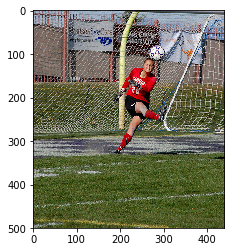

Greedy: man in red shirt is standing on the water


In [56]:
pic = test[np.random.randint(1,1000)]
image = features[pic].reshape((1,2048))
x=plt.imread("Flicker8k_Dataset//"+pic+".jpg")
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))